In [1]:
data = catalog.load("ena-diario-parana")
data.head()

2021-12-09 12:44:31,269 - kedro.io.data_catalog - INFO - Loading data from `ena-diario-parana` (CSVDataSet)...


,nom_bacia,ena_bruta_bacia_mwmed,ena_bruta_bacia_percentualmlt,ena_armazenavel_bacia_mwmed,ena_armazenavel_bacia_percentualmlt
ena_data,,,,,
2000-01-01,PARANA,12073.358398,58.836899,12073.358398,58.836899
2000-01-02,PARANA,12579.799805,61.305000,12579.799805,61.305000
2000-01-03,PARANA,13393.181641,65.268799,13393.181641,65.268799
2000-01-04,PARANA,14473.228516,70.532204,14473.228516,70.532204
2000-01-05,PARANA,15750.317383,76.755798,15750.317383,76.755798


# Generate Windows

In [16]:
import pandas as pd

def generate_windows(df, window_size, shift):
    N = len(data)
    n = N//window_size
    
    df = df.reset_index()
    
    windows = []

    k = 0
    window_id = 1
    while (N-k-window_size) >= 0:
        window = df[['ena_data','ena_bruta_bacia_mwmed']].iloc[(N-k-window_size):(N-k)].reset_index()
        window['window_id'] = window_id
        window['window_index'] = range(0,window_size)
        window.set_index('ena_data',inplace=True)
        
        piv = window.pivot(index='window_id', columns='window_index', values="ena_bruta_bacia_mwmed")
        piv['from_date'] = min(window.index.date)
        piv['to_date'] = max(window.index.date)
        
        windows.append(piv)
        
        k = k + shift
        window_id += 1
        
    return pd.concat(windows)

In [18]:
input_width = 128
target_width = 15

window_size = input_width + target_width
shift = 1

windows = generate_windows(data, window_size, shift)

# Split data

In [75]:
def split_data(data, split = [.7,.1,.2]):

    N = len(data)

    n_valid = int(split[1]*N) 
    n_test  = int(split[2]*N)
    n_train = N - n_valid - n_test

    train = data[:n_train]
    valid = data[n_train:n_train+n_valid]
    test = data[n_train+n_valid:n_train+n_valid+n_test]
    
    return train, valid, test


In [76]:
train, valid, test = split_data(windows)

In [213]:
def split_xy(data, input_width):
    ts_values = data.drop(['from_date','to_date'], axis=1)
    
    x_col = ts_values.columns[:input_width]
    y_col = ts_values.columns[input_width:]
    
    return ts_values[x_col], ts_values[y_col]

In [82]:
train_x, train_y = split_xy(train, input_width)
valid_x, valid_y = split_xy(valid, input_width)
test_x, test_y = split_xy(test, input_width)

# Normalizing data

Calculate sample average and standard deviation for z-score

In [45]:
# Remove last columns with datetime
ts_data = train.values[:,:-2]


train_avg = ts_data.reshape(1,ts_data.shape[0]*ts_data.shape[1]).mean()
train_std = ts_data.reshape(1,ts_data.shape[0]*ts_data.shape[1]).std()

print("Train Average: {}".format(train_avg))
print("Train SD: {}".format(train_std))

Train Average: 15713.496003778675
Train SD: 7605.160823433812


Calculate Z-score

In [88]:
def zscore(data, avg, std):
    
    scaled = data.sub(avg)
    scaled = scaled.divide(std)
    
    return scaled

In [195]:
scaled_train_x = zscore(train_x, train_avg, train_std)
scaled_train_y = zscore(train_y, train_avg, train_std)
scaled_valid_x = zscore(valid_x, train_avg, train_std)
scaled_valid_y = zscore(valid_y, train_avg, train_std)
scaled_test_x  = zscore(test_x, train_avg, train_std)
scaled_test_y  = zscore(test_y, train_avg, train_std)

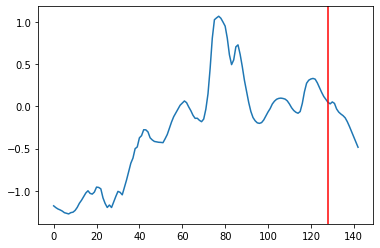

In [153]:
import numpy as np
import matplotlib.pyplot as plt

window_id = 251

plt.plot(np.concatenate([scaled_train_x.iloc[window_id].values,scaled_train_y.iloc[window_id].values]))
plt.axvline(x=128, color='r')

# Extracting Features

In [210]:
def extract_features(ts, wavelet, include_ts = True):
    
    level = int(np.log(len(ts)))
    if include_ts is True:
        features = ts
    else:
        features = np.array([])
        
    cA = ts
    for l in range(1,level+1):
        cA, cD = pywt.dwt(cA, wavelet)
        
        features = np.concatenate([features,cD])
        
    features = np.concatenate([features,cA])
    
    return features

In [208]:
%%time

scaled_train_x = zscore(train_x, train_avg, train_std)
scaled_train_y = zscore(train_y, train_avg, train_std)
scaled_valid_x = zscore(valid_x, train_avg, train_std)
scaled_valid_y = zscore(valid_y, train_avg, train_std)
scaled_test_x  = zscore(test_x, train_avg, train_std)
scaled_test_y  = zscore(test_y, train_avg, train_std)

scaled_train_x = scaled_train_x.apply(lambda x: extract_features(x), axis=1, result_type='expand')
scaled_valid_x = scaled_valid_x.apply(lambda x: extract_features(x), axis=1, result_type='expand')
scaled_test_x  = scaled_test_x.apply(lambda x: extract_features(x), axis=1, result_type='expand')

CPU times: user 2 s, sys: 46.8 ms, total: 2.05 s
Wall time: 2.09 s


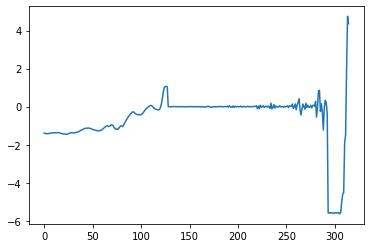

In [209]:
plt.plot(scaled_train_x.values[300])

# Creating a generalized function

Required functions from above

In [215]:
import pywt
import pandas as pd
import numpy as np


def generate_windows(df, window_size, shift):
    N = len(data)
    n = N//window_size
    
    df = df.reset_index()
    
    windows = []

    k = 0
    window_id = 1
    while (N-k-window_size) >= 0:
        window = df[['ena_data','ena_bruta_bacia_mwmed']].iloc[(N-k-window_size):(N-k)].reset_index()
        window['window_id'] = window_id
        window['window_index'] = range(0,window_size)
        window.set_index('ena_data',inplace=True)
        
        piv = window.pivot(index='window_id', columns='window_index', values="ena_bruta_bacia_mwmed")
        piv['from_date'] = min(window.index.date)
        piv['to_date'] = max(window.index.date)
        
        windows.append(piv)
        
        k = k + shift
        window_id += 1
        
    return pd.concat(windows)


def split_data(data, split = [.7,.1,.2]):

    N = len(data)

    n_valid = int(split[1]*N) 
    n_test  = int(split[2]*N)
    n_train = N - n_valid - n_test

    train = data[:n_train]
    valid = data[n_train:n_train+n_valid]
    test = data[n_train+n_valid:n_train+n_valid+n_test]
    
    return train, valid, test


def split_xy(data, input_width):
    ts_values = data.drop(['from_date','to_date'], axis=1)
    
    x_col = ts_values.columns[:input_width]
    y_col = ts_values.columns[input_width:]
    
    return ts_values[x_col], ts_values[y_col]


def zscore(data, avg, std):
    
    scaled = data.sub(avg)
    scaled = scaled.divide(std)
    
    return scaled

def extract_features(ts, wavelet, include_ts = True):
    
    level = int(np.log(len(ts)))
    if include_ts is True:
        features = ts
    else:
        features = np.array([])
        
    cA = ts
    for l in range(1,level+1):
        cA, cD = pywt.dwt(cA, wavelet)
        
        features = np.concatenate([features,cD])
        
    features = np.concatenate([features,cA])
    
    return features

Generalized function

In [224]:
def generate_training_data(data, input_width, target_width, wavelet, include_ts, shift, split):
    
    # Generate Windows
    window_size = input_width + target_width
    windows = generate_windows(data, window_size, shift)
    
    # Split training data
    train, valid, test = split_data(windows, split)
    
    # Split X and Y
    train_x, train_y = split_xy(train, input_width)
    valid_x, valid_y = split_xy(valid, input_width)
    test_x, test_y = split_xy(test, input_width)
    
    # Scale Data with Training Dataset
    ts_data = train.values[:,:-2] # Remove last columns with datetime

    train_avg = ts_data.reshape(1,ts_data.shape[0]*ts_data.shape[1]).mean()
    train_std = ts_data.reshape(1,ts_data.shape[0]*ts_data.shape[1]).std()
    
    scaled_train_x = zscore(train_x, train_avg, train_std)
    scaled_train_y = zscore(train_y, train_avg, train_std)
    scaled_valid_x = zscore(valid_x, train_avg, train_std)
    scaled_valid_y = zscore(valid_y, train_avg, train_std)
    scaled_test_x  = zscore(test_x, train_avg, train_std)
    scaled_test_y  = zscore(test_y, train_avg, train_std)
    
    
    # Extract Features
    def get_dwt(x):    
        return extract_features(x, wavelet, include_ts)
    
    if wavelet == None:
        return (scaled_train_x, scaled_valid_x, scaled_test_x,
                scaled_train_y, scaled_valid_y, scaled_test_y)
    else:
        dwt_scaled_train_x = scaled_train_x.apply(lambda x: get_dwt(x), axis=1, result_type='expand')
        dwt_scaled_valid_x = scaled_valid_x.apply(lambda x: get_dwt(x), axis=1, result_type='expand')
        dwt_scaled_test_x  = scaled_test_x.apply(lambda x: get_dwt(x), axis=1, result_type='expand')
    
        return (dwt_scaled_train_x, dwt_scaled_valid_x, dwt_scaled_test_x,
                scaled_train_y, scaled_valid_y, scaled_test_y)

In [252]:
# Training data generation parameters

data         = catalog.load("ena-diario-parana")
input_width  = 128
target_width = 15 
wavelet      = 'db8'
include_ts   = True
shift        = 1
split        = [.7, .1, .2]

2021-12-09 15:47:28,387 - kedro.io.data_catalog - INFO - Loading data from `ena-diario-parana` (CSVDataSet)...


In [253]:
%%time

X_train, X_valid, X_test, Y_train, Y_valid, Y_test = generate_training_data(
    data, input_width, target_width, wavelet, include_ts, shift, split
)

CPU times: user 1min 26s, sys: 322 ms, total: 1min 27s
Wall time: 1min 28s


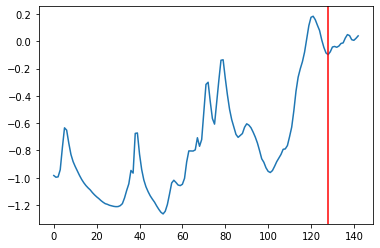

In [248]:
window_id = 1000

plt.plot(np.concatenate([X_test.values[window_id], Y_test.values[window_id]]))
horizon = len(X_test.values[window_id])
plt.axvline(x=horizon, color='r')

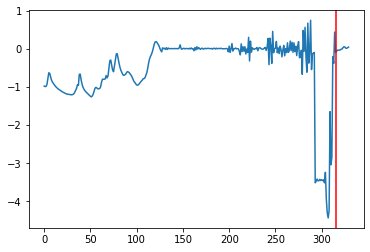

In [251]:
window_id = 1000

plt.plot(np.concatenate([X_test.values[window_id], Y_test.values[window_id]]))
horizon = len(X_test.values[window_id])
plt.axvline(x=horizon, color='r')

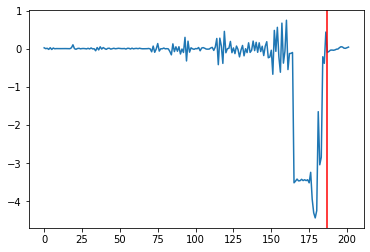

In [256]:
window_id = 1000

plt.plot(np.concatenate([X_test.values[window_id], Y_test.values[window_id]]))
horizon = len(X_test.values[window_id])
plt.axvline(x=horizon, color='r')